In [1]:
import pandas as pd
import warnings 
import numpy as np

warnings.filterwarnings('ignore')

df = pd.read_csv('../price.csv',index_col=['stock_id','date'],parse_dates=['date'])
df = df.rename(columns={
    '開盤價':'open',
    '最高價':'high',
    '最低價':'low',
    '收盤價':'close',
    '成交金額':'volume'
})
df = df[['open','high','low','close','volume']]
df = df.loc[df['volume']>0]
df = df.apply(pd.to_numeric,errors='coerce')
df = df.loc['2886']
df

,open,high,low,close,volume
date,,,,,
2007-01-02,23.95,24.50,23.85,24.35,576149809
2007-01-03,24.50,24.70,24.35,24.35,303218381
2007-01-04,24.50,24.60,24.10,24.20,260015599
2007-01-05,23.95,23.95,23.35,23.40,460313711
2007-01-08,23.25,23.25,23.00,23.05,443724567
...,...,...,...,...,...
2022-06-28,36.45,36.50,36.20,36.35,400215598
2022-06-29,35.80,36.10,35.55,35.70,701463568
2022-06-30,35.50,35.70,35.20,35.30,721785064


<AxesSubplot:>

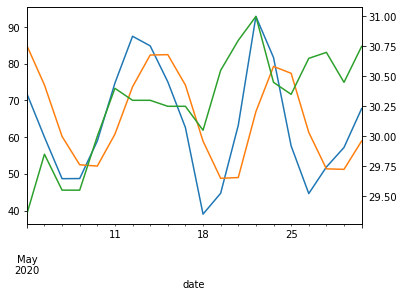

In [2]:
import talib
import talib.abstract as abstract

# talib.get_functions()
abstract.STOCH(df)['2020-05']['slowk'].plot()
abstract.STOCH(df)['2020-05']['slowd'].plot()
df['close']['2020-05'].plot(secondary_y=True)

In [3]:
abstract.STOCH(df)

,slowk,slowd
date,,
2007-01-02,NaN,NaN
2007-01-03,NaN,NaN
2007-01-04,NaN,NaN
2007-01-05,NaN,NaN
2007-01-08,NaN,NaN
...,...,...
2022-06-28,76.985020,65.107893
2022-06-29,62.292038,68.095056
2022-06-30,40.984848,60.087302


<AxesSubplot:xlabel='date'>

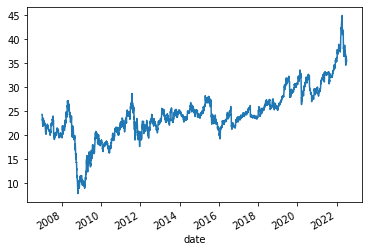

In [6]:
df['close'].plot()

2 6 14 60 1.6799999999999997
2 6 14 72 6.68
2 6 14 81 16.68
2 6 20 81 19.23
2 6 20 82 21.38
2 6 25 73 21.380000000000003
2 6 26 72 23.080000000000005
2 6 26 73 24.280000000000005
2 6 27 73 25.180000000000003
2 6 32 71 26.620000000000005
2 7 28 71 27.229999999999997
2 7 29 71 29.679999999999996
2 8 31 72 30.229999999999997
3 8 28 77 30.709999999999997


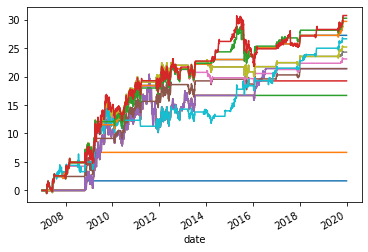

In [9]:
df2 = df.copy()

df2 = df2[:'2019']

highest_earning = 0 

for fastkd in range(2,5,1):
    for slowkd in range(6,12,1):

        kd = abstract.STOCH(df2,fastk_period=fastkd,slowk_period=slowkd,slowd_period=slowkd)

        df2['k'] = kd['slowk']
        df2['d'] = kd['slowd']
        
        for lowKD in range(14,40,1):
            for highKD in range(60,90,1):

                df2['hold'] = np.nan
                df2.loc[(df2['k'].shift(1)<df2['d'].shift(1))&(df2['k']>df2['d'])&(df2['d']<lowKD),'hold'] = 1
                df2.loc[(df2['k'].shift(1)>df2['d'].shift(1))&(df2['k']<df2['d'])&(df2['d']>highKD),'hold'] = 0

                df2['hold'].ffill(inplace=True)
                df2['hold'] = df2['hold'].fillna(0)

                df2['earn'] = 0
                df2['earn'].loc[df2['hold']==1] = df2['open'].shift(-2)-df2['open'].shift(-1)

               
                
                if df2['earn'].cumsum().dropna().iloc[-1]>highest_earning:
                    print(fastkd,slowkd,lowKD,highKD,df2['earn'].cumsum().dropna().iloc[-1])
                    df2['earn'].cumsum().plot()
                    highest_earning = df2['earn'].cumsum().dropna().iloc[-1]

4 11 39 89 30.459999999999994


Start date,2007-01-02
End date,2022-07-04
Total months,181
,Backtest
Annual return,11.161%
Cumulative returns,397.038%
Annual volatility,19.337%
Sharpe ratio,0.64
Calmar ratio,0.36
Stability,0.79
Max drawdown,-31.393%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.39,2015-04-23,2016-01-20,2021-02-05,1512
1,25.41,2008-12-15,2009-02-27,2009-03-20,70
2,22.36,2009-09-29,2010-06-03,2010-09-13,250
3,20.38,2009-04-10,2009-04-27,2009-05-19,28
4,19.43,2008-11-03,2008-11-19,2008-12-01,21


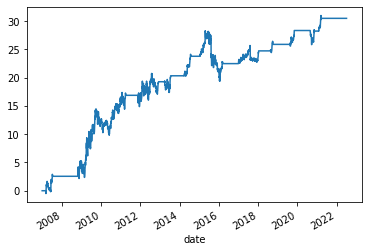

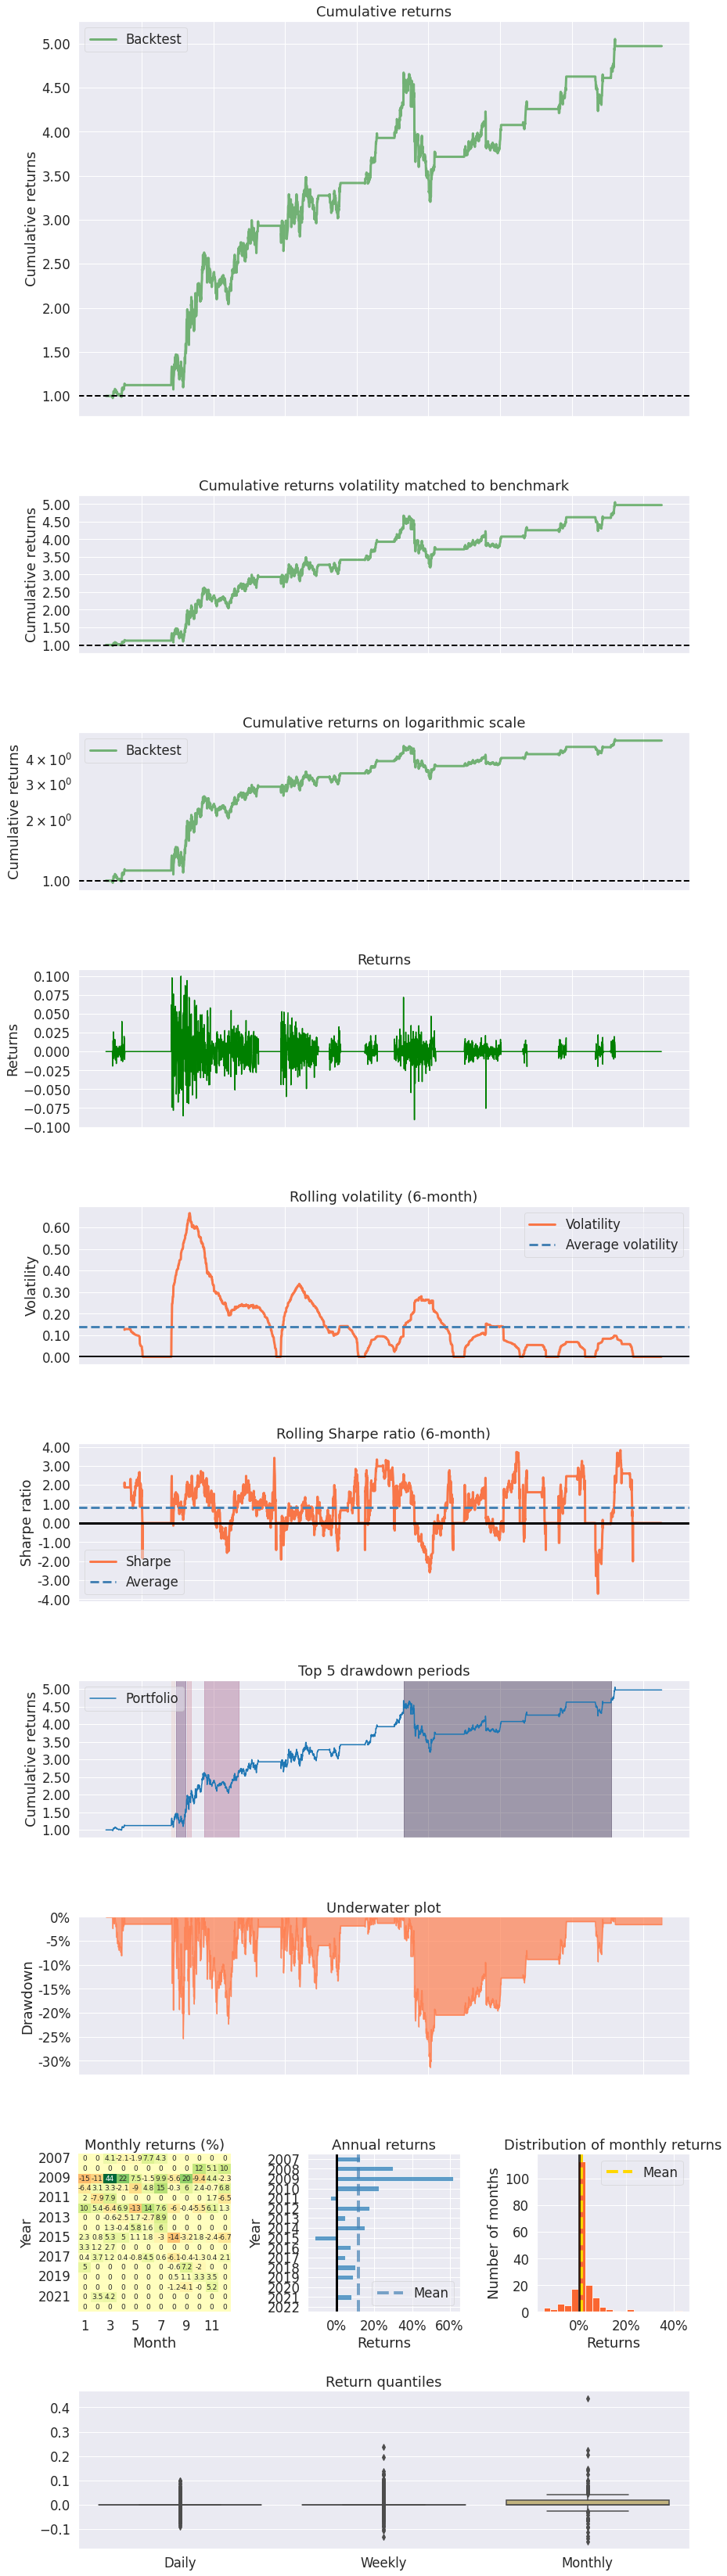

In [12]:
kd = abstract.STOCH(df,fastk_period=3,slowk_period=8,slowd_period=8)

df['k'] = kd['slowk']
df['d'] = kd['slowd']


df['hold'] = np.nan
df.loc[(df['k'].shift(1)<df['d'].shift(1))&(df['k']>df['d'])&(df['d']<27),'hold'] = 1
df.loc[(df['k'].shift(1)>df['d'].shift(1))&(df['k']<df['d'])&(df['d']>77),'hold'] = 0

df['hold'].ffill(inplace=True)
df['hold'] = df['hold'].fillna(0)

df['earn'] = 0
df['earn'].loc[df['hold']==1] = df['open'].shift(-2)-df['open'].shift(-1)

print(fastkd,slowkd,lowKD,highKD,df['earn'].cumsum().dropna().iloc[-1])

# df['earn'] = df['earn'].loc['2020':]

df['earn'].cumsum().plot()

import pyfolio as pf

pf.create_returns_tear_sheet((df['earn']/df['open'].shift(-1)))